In [1]:
using Turing
using DataFrames
using CSV
using Random
using Distributions
using StatisticalRethinking
using StatisticalRethinking: link
using StatisticalRethinkingPlots
using ParetoSmooth
using StatsPlots
using Plots.PlotMeasures
using StatsBase
using FreqTables
using Logging

default(label=false);
Logging.disable_logging(Logging.Warn);

# 13.1 Example: multilevel tadpoles

Code 13.1

In [2]:
d = DataFrame(CSV.File("data/reedfrogs.csv"))
describe(d)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Union…,Any,Union…,Any,Int64,DataType
1,density,23.3333,10,25.0,35,0,Int64
2,pred,,no,,pred,0,String7
3,size,,big,,small,0,String7
4,surv,16.3125,4,12.5,35,0,Int64
5,propsurv,0.721607,0.114286,0.885714,1.0,0,Float64


Code 13.2

In [3]:
d.tank = 1:nrow(d)

@model function m13_1(S, N, tank)
    tank_size = length(levels(d.tank))
    a ~ filldist(Normal(0, 1.5), tank_size)
    p = logistic.(a)
    @. S ~ Binomial(N, p)
end

Random.seed!(1)
m13_1_ch = sample(m13_1(d.surv, d.density, d.tank), NUTS(200, 0.65, init_ϵ=0.5), 1000)
m13_1_df = DataFrame(m13_1_ch);

Code 13.3

In [4]:
@model function m13_2(S, N, tank)
    tank_size = length(levels(d.tank))
    σ ~ Exponential()
    ā ~ Normal(0, 1.5)
    a ~ filldist(Normal(ā, σ), tank_size)
    p = logistic.(a)
    @. S ~ Binomial(N, p)
end

Random.seed!(1)
m13_2_ch = sample(m13_2(d.surv, d.density, d.tank), NUTS(200, 0.65, init_ϵ=0.2), 1000)
m13_2_df = DataFrame(m13_2_ch);

Code 13.4

In [5]:
link_fun = (r, dr) -> begin
    a = get(r, "a[$(dr.tank)]", 0)
    p = logistic(a)
    binomlogpdf(dr.density, p, dr.surv)
end

m1_ll = link(m13_1_df, link_fun, eachrow(d))
m1_ll = hcat(m1_ll...);

m2_ll = link(m13_2_df, link_fun, eachrow(d))
m2_ll = hcat(m2_ll...);

compare([m1_ll, m2_ll], :waic, mnames=["m13.1", "m13.2"])

,models,WAIC,lppd,SE,dWAIC,dSE,pWAIC,weight
,String,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,m13.2,201.2,158.41,7.47,0.0,0.0,21.4,1.0
2,m13.1,214.7,163.28,4.68,13.5,3.99,25.71,0.0


Code 13.5

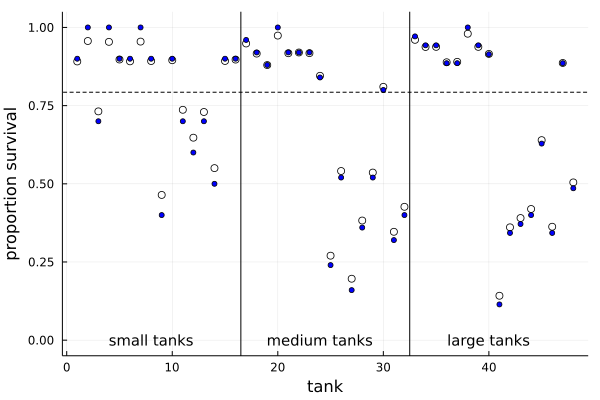

In [6]:
Random.seed!()
post = sample(resetrange(m13_2_ch), 10000)
post_df = DataFrame(post)

propsurv_est = [
    logistic(mean(post_df[:,"a[$i]"]))
    for i ∈ 1:nrow(d)
]

scatter(propsurv_est, mc=:white, xlab="tank", ylab="proportion survival", ylim=(-0.05, 1.05))
scatter!(d.propsurv, mc=:blue, ms=3)
hline!([mean(logistic.(post_df.ā))], ls=:dash, c=:black)
vline!([16.5, 32.5], c=:black)
annotate!([
        (8, 0, ("small tanks", 10)),
        (16+8, 0, ("medium tanks", 10)),
        (32+8, 0, ("large tanks", 10))
    ])

Code 13.6

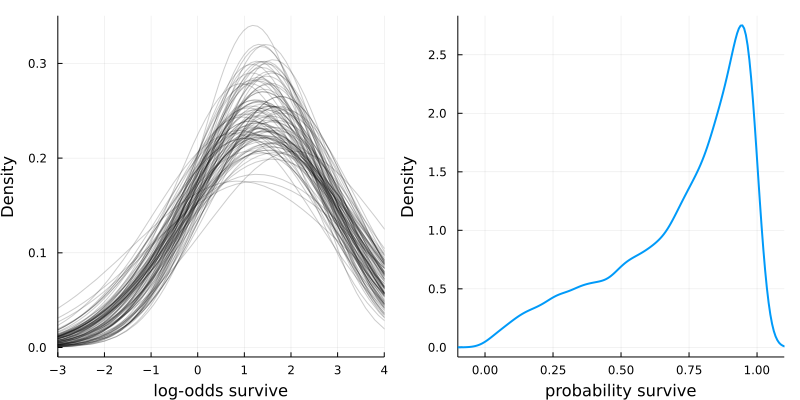

In [7]:
p1 = plot(xlim=(-3, 4), xlab="log-odds survive", ylab="Density")

for r ∈ first(eachrow(post_df), 100)
    plot!(Normal(r.ā, r.σ), c=:black, alpha=0.2)
end

sim_tanks = @. rand(Normal(post_df.ā[1:8000], post_df.σ[1:8000]));
p2 = plot(xlab="probability survive", ylab="Density", xlim=(-0.1, 1.1))
density!(logistic.(sim_tanks), lw=2)

plot(p1, p2, size=(800, 400), margin=2mm)

# 13.2 Varying effects and the underfitting/overfitting trade-off